In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

X_mnist_train = x_train.reshape((len(x_train), 28, 28, 1))
X_mnist_test = x_test.reshape((len(x_test), 28, 28, 1))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [2]:
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [3]:
def generate_real_samples(dataset: np.ndarray, n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, dataset.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    random_samples = random_samples.reshape((n_samples, 28, 28, 1))
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [4]:
import matplotlib.pyplot as plt

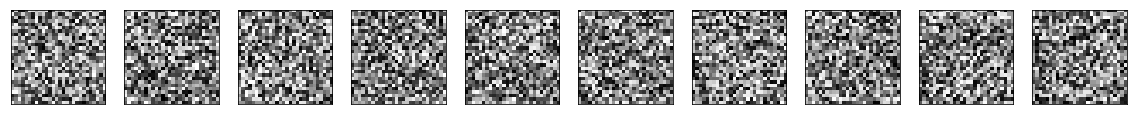

In [5]:
fake_images, _ = generate_fake_samples(10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## About the discriminator
* Since we defined the architecture of the discriminator we are going to train it sequentaly with the whole GAN, not by itself

## Defining a generator

In [6]:
from keras.layers import Reshape, Conv2DTranspose

In [7]:
def generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
        
    return model

In [8]:
generator = generator_model(100)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       262272    
__________

In [9]:
def generate_latent_points(latent_dim: int, n_samples: int) -> np.ndarray:
    
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [10]:
def generate_fake_generator_samples(generator: Model, latent_dim: int, n_samples: int) -> (np.ndarray, np.ndarray):
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1)) # Zeros because we want to convince the generator that these are fakes
    
    return X, y

### Initial generator examples

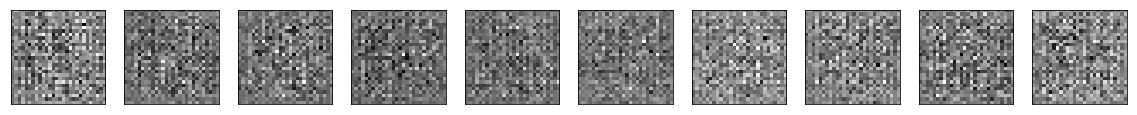

In [11]:
initial_generator_samples, _ = generate_fake_generator_samples(generator, 100, 10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(initial_generator_samples[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Defining a GAN

In [12]:
from keras.models import Sequential

In [13]:
def define_gan(g_model: Model, d_model: Model) -> Model:
    
    d_model.trainable = False
    
    model = Sequential()
    
    model.add(g_model)
    
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [14]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         1164289   
_________________________________________________________________
model_1 (Model)              (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Training the GAN model

In [15]:
def test_generator(generator: Model, data: np.ndarray):
    
    generator_output = generator.predict(data)
    plt.figure(figsize=(20, 20))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generator_output[i].reshape((28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [16]:
print(f'Disc metrics: {discriminator.metrics_names}')
print(f'GAN metrics: {gan_model.metrics_names}')

Disc metrics: ['loss', 'acc']
GAN metrics: ['loss', 'acc']


### Setting up tensorboard

In [19]:
from keras.callbacks import TensorBoard, Callback
import tensorflow as tf
import io

In [59]:
class image_writer(Callback):
    
    def __init__(self, log_dir: str, latent_dim: int):
        self.noise = generate_latent_points(latent_dim, 5)
#         self.file_writer = tf.summary.FileWriter(log_dir)
        self.log_dir = log_dir
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch % 5 != 0:
            return
        
        epoch_output = self.model.predict(self.noise)
        
        figure = plt.figure(figsize=(25, 5))
        for i in range(5):
            ax = plt.subplot(1, 10, i + 1)
            plt.imshow(epoch_output[i].reshape((28, 28)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.savefig(f'{self.log_dir}/generated_digits_{epoch}.png', bbox_inches='tight')
#         buf = io.BytesIO()
#         plt.savefig(buf, format='png')
#         image_string = buf.getvalue()
#         plt.close(figure)
        
#         image = tf.Summary.Image(height=28,
#                                  width=28,
#                                  colorspace=1,
#                                  encoded_image_string=image_string)
        
# #         loss = tf.summary.scalar('loss', logs['loss'])
# #         val_loss = tf.summary.scalar('loss', logs['val_loss'])
# #         acc = tf.summary.scalar('loss', logs['acc'])
# #         val_acc = tf.summary.scalar('loss', logs['val_acc'])
        
#         summary = tf.Summary(value=[tf.Summary.Value(image=image)])
# #         summary2 = tf.Summary(value=[tf.Summary.Value(scalar=loss)])
# #         summary3 = tf.Summary(value=[tf.Summary.Value(scalar=val_loss)])
# #         summary4 = tf.Summary(value=[tf.Summary.Value(scalar=acc)])
# #         summary5 = tf.Summary(value=[tf.Summary.Value(scalar=val_acc)])
#         self.file_writer.add_summary(summary, epoch)
# #         self.file_writer.add_summary(summary2, epoch)
# #         self.file_writer.add_summary(summary3, epoch)
# #         self.file_writer.add_summary(summary4, epoch)
# #         self.file_writer.add_summary(summary5, epoch)
# #         self.file_writer.add_summary(loss, epoch)
# #         self.file_writer.add_summary(val_loss, epoch)
# #         self.file_writer.add_summary(val_acc, epoch)

In [60]:
def tensorboard(log_dir, batch_size: int, model: Model) -> TensorBoard:
    
    _tensorboard = TensorBoard(log_dir=log_dir,
                               histogram_freq=0,
                               batch_size=batch_size,
                               write_graph=True, 
                               write_grads=True)
    
    _tensorboard.set_model(model)
    
    print(f'Initialized Tensorboard with logdir={log_dir}')
    
    return _tensorboard



def named_logs(model: Model, logs) -> dict:
    # Creates a dictionary mapping model metrics to log data
    # eg. for GAN metrics are ['loss', 'acc'], so logs should be eg. [0.23, 0.95]
    
    result = {}
    
    for metric, value in zip(model.metrics_names, logs):
        result[metric] = value
    
    return result

def named_logs(metrics: list, logs: list) -> dict:
    # Creates a dictionary mapping metrics to log data
    # eg. for GAN metrics are ['loss', 'acc'], so logs should be eg. [0.23, 0.95]
    
    result = {}
    
    for metric, value in zip(metrics, logs):
        result[metric] = value
    
    return result

def s_named_logs(metrics:list, logs: list) -> str:
        
        logs = named_logs(metrics, logs)
        
        return ', '.join([f'{key}: {val}' for key, val in logs.items()])

### Restarting models

In [67]:
discriminator = discriminator_model()
generator = generator_model(200)
gan_model = define_gan(generator, discriminator)

In [68]:
def train(name: str, g_model: Model, d_model: Model, gan_model: Model, dataset: np.ndarray, latent_dim: int, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2)

    log_path = f'tf_logs/{name}'
    
    _tensorboard = tensorboard(log_path, n_batch, gan_model)
    image_vis = image_writer(log_path, latent_dim)
    image_vis.set_model(g_model)
    
    metrics = ['loss', 'acc', 'val_loss', 'val_acc']
    
    test_data = generate_latent_points(latent_dim, 10)
    
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_generator_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, d_acc = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))
            
            # List of scalars loss, acc
            # This is the model we are most interested in learning so
            # its progress is going to be tracked with Tensorboard
            gan_loss, gan_acc = gan_model.train_on_batch(X_gan, y_gan)
            
            X_val_gan = generate_latent_points(latent_dim, n_batch)
            
            y_val_gan = np.ones((n_batch, 1))
            
            gan_val_loss, gan_val_acc = gan_model.test_on_batch(X_val_gan, y_val_gan)
            
            gan_logs =  [gan_loss, gan_acc, gan_val_loss, gan_val_acc]
            gan_logs_dic = s_named_logs(metrics, gan_logs)
            
            if (j) % 3 == 0:
                print('.', end='')
            if (j + 1) % batches_per_epoch == 0:
                print(f'{i+1}, d_loss={d_loss}, d_acc={d_acc}, gan={gan_logs_dic}')
        
                
        print('epoch over, writing callbacks')
        
        _tensorboard.on_epoch_end(i + 1, named_logs(metrics, gan_logs))
        image_vis.on_epoch_end(i + 1)

        
#         if (i + 1) % 5 == 0:
#             test_generator(g_model, test_data)

Initialized Tensorboard with logdir=tf_logs/latent_dim_200


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


...............................................................................................1, d_loss=0.8713910579681396, d_acc=0.4140625, gan=loss: 0.8363760709762573, acc: 0.28515625, val_loss: 0.8071130514144897, val_acc: 0.08203125
epoch over, writing callbacks
...............................................................................................2, d_loss=0.7080962657928467, d_acc=0.52734375, gan=loss: 0.7006638646125793, acc: 0.49609375, val_loss: 0.6750544905662537, val_acc: 0.5546875
epoch over, writing callbacks
...............................................................................................3, d_loss=0.6325334906578064, d_acc=0.7109375, gan=loss: 0.8179144263267517, acc: 0.171875, val_loss: 0.7887462973594666, val_acc: 0.09765625
epoch over, writing callbacks
...............................................................................................4, d_loss=0.7058820128440857, d_acc=0.4140625, gan=loss: 0.6933209300041199, acc: 0.53125, val_loss:

...............................................................................................32, d_loss=0.6878913640975952, d_acc=0.546875, gan=loss: 0.6598540544509888, acc: 0.69921875, val_loss: 0.658426821231842, val_acc: 0.93359375
epoch over, writing callbacks
...............................................................................................33, d_loss=0.6944011449813843, d_acc=0.5, gan=loss: 0.7387666702270508, acc: 0.30078125, val_loss: 0.7182676792144775, val_acc: 0.1640625
epoch over, writing callbacks
...............................................................................................34, d_loss=0.683344841003418, d_acc=0.53515625, gan=loss: 0.7111014127731323, acc: 0.44140625, val_loss: 0.70318603515625, val_acc: 0.328125
epoch over, writing callbacks
...............................................................................................35, d_loss=0.6861950755119324, d_acc=0.53125, gan=loss: 0.7099887132644653, acc: 0.43359375, val_loss: 0.703

...............................................................................................63, d_loss=0.6921765804290771, d_acc=0.5390625, gan=loss: 0.7358100414276123, acc: 0.328125, val_loss: 0.7236651182174683, val_acc: 0.0546875
epoch over, writing callbacks
...............................................................................................64, d_loss=0.6947461366653442, d_acc=0.51953125, gan=loss: 0.7014490962028503, acc: 0.421875, val_loss: 0.7023831009864807, val_acc: 0.3359375
epoch over, writing callbacks
...............................................................................................65, d_loss=0.6861907243728638, d_acc=0.54296875, gan=loss: 0.6906781792640686, acc: 0.546875, val_loss: 0.6975657939910889, val_acc: 0.453125
epoch over, writing callbacks
...............................................................................................66, d_loss=0.6832566261291504, d_acc=0.5625, gan=loss: 0.6680857539176941, acc: 0.65625, val_loss: 0.66

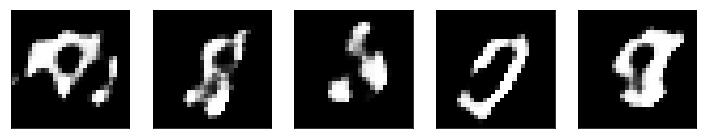

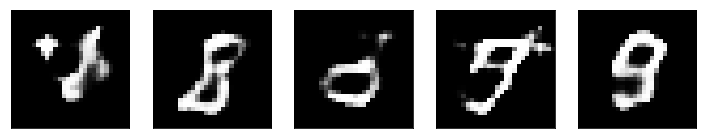

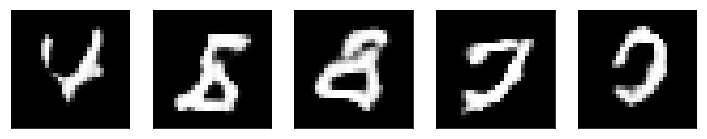

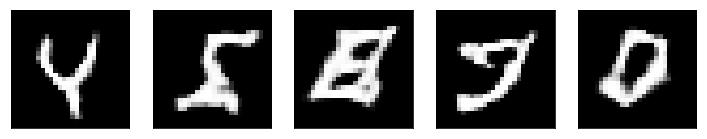

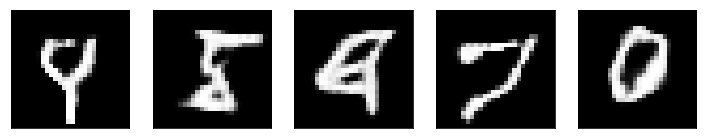

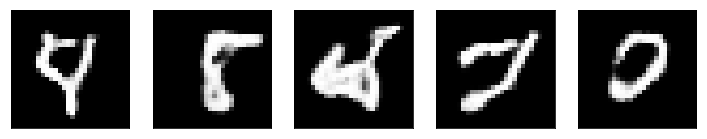

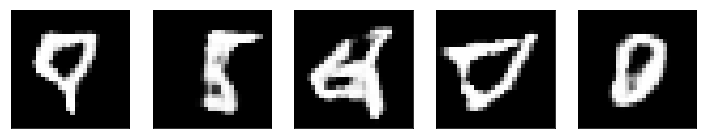

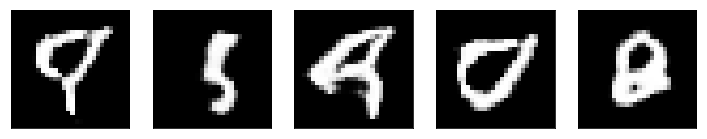

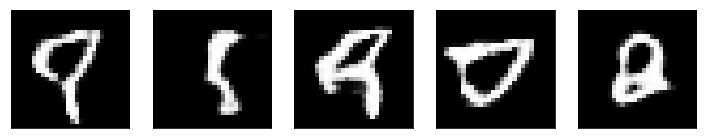

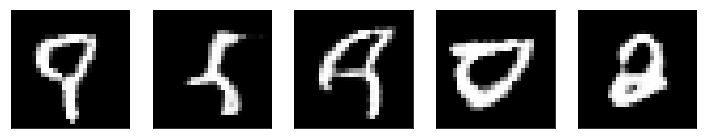

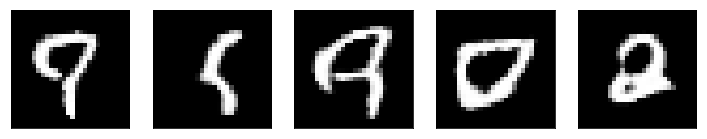

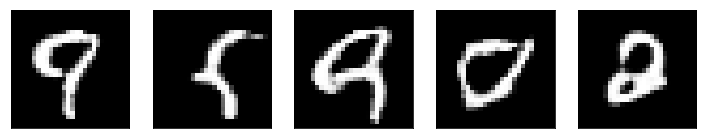

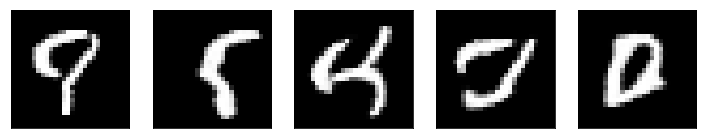

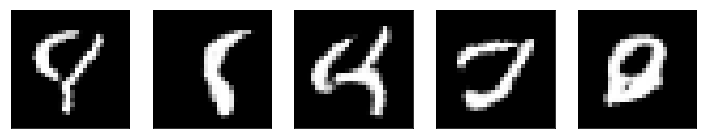

In [69]:
train('latent_dim_200', generator, discriminator, gan_model, X_mnist_train[:20000], latent_dim=200, n_epochs=70)

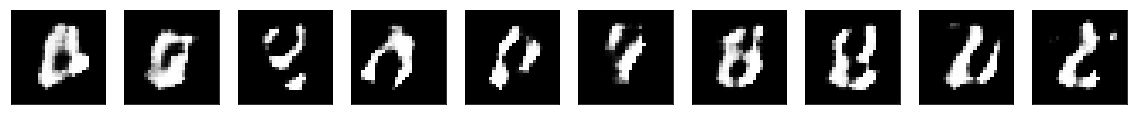

In [103]:
test_generator(generator, 100, 10)

In [119]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
# Obavezno ukljuciti u MNIST barem 10000 primjera za učenje za efektivno učenje

In [72]:
print(tf.__version__)

1.6.0
